# Exercise 09 - Topology optimization for continua


## Task 1 - Book shelf

Let us consider a bookshelf that needs a support structure. The design domain is given by a unit square $x \in [0, 1]^2$ and a maximum thickness $d_{max}=0.1$. The left boundary of the domain $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

<div>
    <center>
        <img src="../figures/domain.png" width="250"/>
    </center>
</div>


In [97]:
from math import sqrt

import torch
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress

torch.set_default_dtype(torch.double)

a) Modify the solution from last exercise and increase the number of elements per direction $N$ to 20.

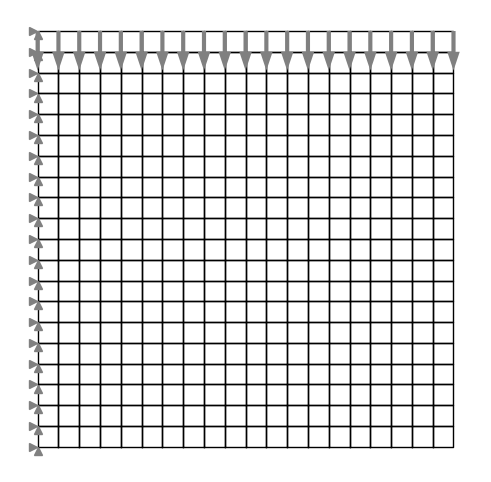

In [98]:
# Define Material
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

# Create nodes
N = 20
n1 = torch.linspace(0.0, 1.0, N + 1)
n2 = torch.linspace(0.0, 1.0, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])
elements = torch.tensor(elements)

# Load at top
forces = torch.zeros_like(nodes)
forces[N * (N + 1) : (N + 1) * (N + 1), 1] = -1.0 / N

# Constrained displacement at left end
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
for i in range(N + 1):
    constraints[i * (N + 1), :] = True

# Thickness
d = 0.1
thickness = d * torch.ones(len(elements))


# Create and plot the domain
square = Planar(
    nodes, elements, forces, displacements, constraints, thickness, C=material.C()
)
square.plot()

To save material, the bookshelf should use only 40% of the given design space, while being as stiff as possible to support many books. We want to achieve this by topology optimization of the component. You are provided with a function that performs root finding with the bisection method from a previous exercise. 

In [99]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [100]:
def compute_areas(truss):
    areas = torch.zeros((truss.n_elem))
    nodes = truss.nodes[truss.elements, :]
    for w, q in zip(truss.etype.iweights(), truss.etype.ipoints()):
        J = truss.etype.B(q) @ nodes
        detJ = torch.linalg.det(J)
        areas[:] += w * detJ
    return areas

b) Implement a topology optimization algorithm with *optimality conditions* in a function named `optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0)` that takes the FEM model `fem`, the initial density distribution `rho_0`, the minimum and maximum thickness distributions `rho_min, rho_max`, the volume constraint, the maximum iteration count `iter` with a default value of 100, a SIMP penality factor `p` with default 1, and a radius for sensitivity filtering `r` with a default 0.0.

In [101]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0):
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    rho = [rho_0]
    vols = d * compute_areas(fem)

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        ecenters = torch.stack([torch.mean(fem.nodes[e], dim=0) for e in fem.elements])
        dist = torch.cdist(ecenters, ecenters)
        H = r - dist
        H[dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.clamp(rho_trial, lower, upper)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

b) Set up the initial design variables $\rho_0=0.5, \rho_{min}=0.01, \rho_{max}=1.0$ and a volume constraint $V_0= 0.5 V_{max}$ with the maximum design volume $V_{max}$. 

In [102]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(square.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * compute_areas(square)
V0 = 0.4 * vols.sum()

c) Perform the optimization with 80 iterations and the following parameters: 
$$p=3$$
$$r=0$$ 

Iteration k=0 - Compliance: 0.17132
Iteration k=1 - Compliance: 0.32054
Iteration k=2 - Compliance: 0.25135
Iteration k=3 - Compliance: 0.21378
Iteration k=4 - Compliance: 0.18639
Iteration k=5 - Compliance: 0.16247
Iteration k=6 - Compliance: 0.13973
Iteration k=7 - Compliance: 0.11892
Iteration k=8 - Compliance: 0.10088
Iteration k=9 - Compliance: 0.08804
Iteration k=10 - Compliance: 0.07907
Iteration k=11 - Compliance: 0.07191
Iteration k=12 - Compliance: 0.06568
Iteration k=13 - Compliance: 0.06176
Iteration k=14 - Compliance: 0.05940
Iteration k=15 - Compliance: 0.05806
Iteration k=16 - Compliance: 0.05714
Iteration k=17 - Compliance: 0.05655
Iteration k=18 - Compliance: 0.05616
Iteration k=19 - Compliance: 0.05584
Iteration k=20 - Compliance: 0.05563
Iteration k=21 - Compliance: 0.05545
Iteration k=22 - Compliance: 0.05527
Iteration k=23 - Compliance: 0.05510
Iteration k=24 - Compliance: 0.05492
Iteration k=25 - Compliance: 0.05474
Iteration k=26 - Compliance: 0.05453
Iteration k

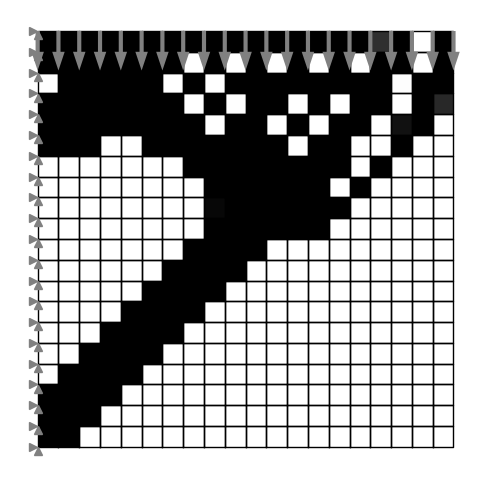

In [103]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=50, p=3.0, r=0.0)
square.plot(element_property=d_opt[-1], cmap="gray_r")

d) Plot the evolution of design variables vs. iterations. What does the graph tell you?

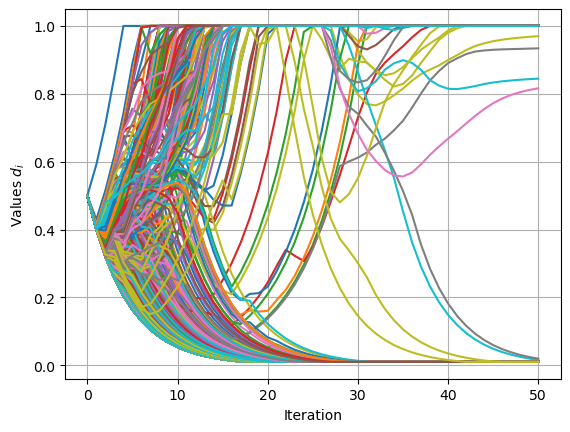

In [104]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

e) Perform the optimization with 250 iterations and the following parameters
$$p=3$$
$$r=0.06$$ 

Iteration k=0 - Compliance: 0.17132
Iteration k=1 - Compliance: 0.32289
Iteration k=2 - Compliance: 0.25248
Iteration k=3 - Compliance: 0.21485
Iteration k=4 - Compliance: 0.18762
Iteration k=5 - Compliance: 0.16400
Iteration k=6 - Compliance: 0.14201
Iteration k=7 - Compliance: 0.12149
Iteration k=8 - Compliance: 0.10354
Iteration k=9 - Compliance: 0.09086
Iteration k=10 - Compliance: 0.08160
Iteration k=11 - Compliance: 0.07466
Iteration k=12 - Compliance: 0.07028
Iteration k=13 - Compliance: 0.06731
Iteration k=14 - Compliance: 0.06517
Iteration k=15 - Compliance: 0.06360
Iteration k=16 - Compliance: 0.06251
Iteration k=17 - Compliance: 0.06176
Iteration k=18 - Compliance: 0.06124
Iteration k=19 - Compliance: 0.06088
Iteration k=20 - Compliance: 0.06058
Iteration k=21 - Compliance: 0.06030
Iteration k=22 - Compliance: 0.06002
Iteration k=23 - Compliance: 0.05973
Iteration k=24 - Compliance: 0.05947
Iteration k=25 - Compliance: 0.05927
Iteration k=26 - Compliance: 0.05913
Iteration k

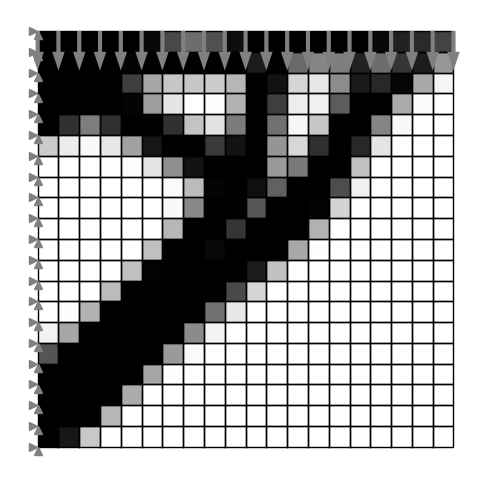

In [105]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=250, p=3.0, r=0.06)
square.plot(element_property=d_opt[-1], cmap="gray_r")

f) How do you interpret the design? Decide which manufacturing process you would like to use and use a CAD software to create a design based on your optimization.